In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
#from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore

from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:

def get_cre_distances(projections, means_cast, sids, cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = means_cast[sids[i]][cres[i]]#means_cast.loc[tuple([cres[i], sids[i]])]
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[i,j]  = np.linalg.norm(meani - meanj)#**2
    return(credist)
def get_loss_surface_cv(projections, centroids, cres, sids,fraction, gamma = 100000):
    means_cast = get_means(projections, cres, sids)
    cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
    surface = get_surface_from_distances(projections,centroids,cre_distances_cv, fraction, gamma)
    surface.cre_distances_cv = cre_distances_cv
    return(surface)

def get_surface_from_distances(projections,centroids,cre_distances, fraction, gamma = 100000):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2

    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

# def get_cre_distances_cv(proj, means_cast, sids,cres):
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         print(i)
#         meani = meani = means_cast[sids[i]][cres[i]]
#         ls = np.where(leafs[sid] == leafs[sid][i])[0]
#         crs = np.where(cres == cres[i])[0]
#         ncr = len(np.intersect1d(ls, crs))
        
#         meanloocvi = meani
#         if ncr > 1:
#             meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         else:
#             meanloocvi = np.zeros(proj[i].shape[0])
#             meanloocvi[:] = np.nan
            
#         for j in range(nsamp):
#             meanj = means_cast[sids[j]][cres[j]]
#             if sids[j] == sids[i]:
#                 credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

#     return(credist)

def get_means(projections, cres, sids):
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    return(cre_means)

def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = meani = means_cast[sids[i]][cres[i]]
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[j,i]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

def get_embedding_cv(surface, dists, cre_distances_cv):
    
    ntrain = dists.shape[0]
    norms = surface.norms
    leaf_pairs = np.asarray(np.where(~np.isnan(cre_distances_cv))).transpose()
    nlp = leaf_pairs.shape[0]
    
    losses = np.zeros((ntrain, ntrain))
    for i in range(nlp):
        d_ij = dists[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[0]
        p_ij = cre_distances_cv[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[1]
        losses[leaf_pairs[i][0]][leaf_pairs[i][1]] = surface.predict(np.asarray([[d_ij, p_ij]]))
      
    losses[np.where(losses == 0)] = np.nan
    
    return(losses)


from mcmodels.core import Mask


def get_embedding(surface, dists, cres = None, cre = None, means = None):
    
    ntrain = dists.shape[0]
    neval = dists.shape[1]
    norms = surface.norms
    #cnorm = surface.cnorm
    
    cre_deezy = np.zeros((ntrain))
    
    for i in range(ntrain):
        cre_deezy[i] = np.linalg.norm(means[cres[i]] - means[cre])
    
    losses = np.zeros((ntrain, neval))
    for i in range(ntrain):
        for j in range(neval):
            d_ij = dists[i,j] / norms[0]
            p_i = cre_deezy[i] / norms[1]
            losses[i,j] = surface.predict(np.asarray([[d_ij, p_i]]))
            
    return(losses)



def get_nw_predictions(projections, dists, gamma):
  
     
    projections = np.asarray(projections, dtype=np.float32)
    neval = dists.shape[1]
    #nexp = centroids.shape[0]
    predictions = np.zeros((neval, projections.shape[1]))
    predictions[:] = np.nan
    
    #print(model_index_val.shape, eval_index_val.shape)
    #weights = np.exp(- dists / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
    for i in range(neval):
        dists_i = dists[:,i] - np.min(dists[:,i])
        #dists_i = dists[i,:] - np.min(dists[i,:])
        weights_i = np.exp(- dists_i * gamma)
        weights_i = np.asarray(weights_i, dtype=np.float32)
        weights_i[np.isnan(weights_i)] = 0.
        weights_i = weights_i / np.sum(weights_i)
        predictions[i] = np.dot(weights_i, projections)
        
    return(predictions) 

def get_connectivity_matrices2_nw(connectivity_data, gamma_dict, cres, structures, model_ordering, source_ordering, target_ordering, eval_cres, cre_model = True):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = model_ordering[i,0]#structure_major_dictionary[source_ordering[i]]
            gamma = gamma_dict[sid]
            connectivity[c,i] = get_region_prediction2(cache,
                                                      connectivity_data.structure_datas[sid],
                                                      exp_structures = structures[sid],
                                                      model_region = model_ordering[i,1],
                                                      prediction_region= source_ordering[i],
                                                      cre = eval_cres[c],
                                                      gamma = gamma_dict[sid],
                                                      cre_model = cre_model)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)


def get_region_prediction2(cache, structure_data,  exp_structures, model_region, prediction_region, cre, gamma, surface = None, cre_model = False):
    
    model_experiments = np.where(exp_structures == model_region)[0]
    nexp = len(model_experiments)
    
    cres = structure_data.crelines[model_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

#     if surface != None and cre_model != True:
#         means = get_means(projections,cres, np.repeat(model_region,nexp))
        
#         losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
#         predictions = get_nw_predictions(projections, losses, gamma)
#         output = np.mean(predictions, axis = 0)
        
    if surface != None and cre_model == True:
        projections = structure_data.reg_proj_norm[model_experiments]
        centroids = structure_data.centroids[model_experiments]
        means = get_means(projections, cres, np.repeat(model_region,nexp))
        #print(means)
        print(prediction_region, model_region,means.keys())
        #supposed to check if theres a cre in that region
        if np.isin(model_region, list(means.keys())):
            if np.isin(cre, np.asarray(list(means[model_region].keys()))):
                losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
                predictions = get_nw_predictions(projections, losses, gamma)
                output = np.mean(predictions, axis = 0)
            else:
                output = np.zeros(projections.shape[1])
                output[:] = np.nan
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan           
#     if surface == None and cre_model != True:
#         means = get_means(projections, cres, [model_region])
#         predictions = means[cres]
#         output = np.mean(predictions, axis = 0)
        
    if surface == None and cre_model == True:
        
        
        modelcre_experiments = np.where(cres == cre)[0]
        if len(modelcre_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
            centroids = structure_data.centroids[model_experiments][modelcre_experiments]
            #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
            
    if surface == None and cre_model == False:
        
        if len(model_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments]
            centroids = structure_data.centroids[model_experiments]
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
        
    return(output)


#good one
#model_ordering_leafs,model_region_structures are len n exps, which model to use
#model_experiments_leaf,model_experiments_structure are inds of 
#cres can be deleted
# def get_connectivity_matrices3(connectivity_data, surfaces, cres, structures_smooth,structures_surface, model_ordering_leafs, model_ordering_surfaces, source_ordering, target_ordering, eval_cres):
    
#     nsource = len(source_ordering)
#     #n#target = len(target_ordering)
#     ncre = len(eval_cres)

#     ipsi_target_regions = connectivity_data.ipsi_target_regions
#     contra_target_regions = connectivity_data.contra_target_regions                               
#     ipsi_indices= np.asarray([])
#     contra_indices = np.asarray([])
#     for iy in target_ordering: 
#         ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
#         contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
#     ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
#     contra_indices = np.asarray(contra_indices, dtype = int)    
#     reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
#     ntarget = len(reorder)
      
#     connectivity = np.zeros((ncre, nsource, ntarget))
#     connectivity[:] = np.nan
#     #structure_major_dictionary = connectivity_data.structure_major_dictionary
#     for c in range(ncre):
#         for i in range(nsource):
#             print(i,source_ordering[i])
#             sid = model_ordering_leafs[i,0]#structure_major_dictionary[source_ordering[i]]
#             gamma = surfaces[sid].gamma#gamma_dict[sid]
#             connectivity[c,i] = get_region_prediction3(cache,
#                                                       connectivity_data.structure_datas[sid],
#                                                       #structures_sid = structures[sid],
#                                                        structures_surface_sid =structures_surface[sid],
#                                                        structures_smooth_sid= structures_smooth[sid],
#                                                       model_region_leaf = model_ordering_leafs[i,1],
#                                                        model_region_surface = model_ordering_surfaces[i,1],
#                                                       prediction_region= source_ordering[i],
#                                                       cre = eval_cres[c],
#                                                       gamma = surfaces[sid].bestgamma,
#                                                       surface = surfaces[sid],
#                                                       cre_model = True)
                                                      
#     connectivity = connectivity[:,:,reorder]                                                  
                                                      
#     return(connectivity)

# def get_region_prediction3(cache, structure_data,  structures_surface_sid,structures_smooth_sid, model_region_surface, model_region_leaf, prediction_region, cre, gamma, surface = None, cre_model = False):
    

#     model_experiments_leaf = np.where(structures_smooth_sid == model_region_leaf)[0]
#     model_experiments_surface = np.where(structures_surface_sid == model_region_surface)[0]
    
#     nexp_surface = len(model_experiments_surface)
    
#     cres_surface = structure_data.crelines[model_experiments_surface]
#     mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)
#     if surface != None and cre_model == True:
#         projections = structure_data.reg_proj_norm[model_experiments_leaf]
#         projections_surface = structure_data.reg_proj_norm[model_experiments_surface]
#         centroids = structure_data.centroids[model_experiments_leaf]#model_region_leaf
#         means = get_means(projections_surface, cres_surface, np.repeat(model_region_surface,nexp_surface))
#         #supposed to check if theres a cre in that region
#         #if np.isin(model_region_surface, list(means.keys())):
#         if centroids.shape[0]>0:
#             if np.isin(cre, np.asarray(list(means[model_region_surface].keys()))):
#                 losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres_surface, cre, means[model_region_surface])
#                 predictions = get_nw_predictions(projections, losses, gamma)
#                 output = np.mean(predictions, axis = 0)
#             else:
#                 output = np.zeros(projections.shape[1])
#                 output[:] = np.nan
#         else:
#             output = np.zeros(projections.shape[1])
#             output[:] = np.nan
#     if surface == None and cre_model == True:
        
        
#         modelcre_experiments = np.where(cres == cre)[0]
#         if len(modelcre_experiments)>0:
#             projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
#             centroids = structure_data.centroids[model_experiments][modelcre_experiments]
#             #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
#             predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
#             output = np.mean(predictions, axis = 0)
#         else:
#             output = np.zeros(structure_data.reg_proj_norm.shape[1])
#             output[:] = np.nan  
            
#     if surface == None and cre_model == False:
        
#         if len(model_experiments)>0:
#             projections = structure_data.reg_proj_norm[model_experiments]
#             centroids = structure_data.centroids[model_experiments]
#             predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
#             output = np.mean(predictions, axis = 0)
#         else:
#             output = np.zeros(structure_data.reg_proj_norm.shape[1])
#             output[:] = np.nan  
       
#     return(output)


In [4]:
#use v3

In [5]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)

#switch from v2 structures
#ontological_order = get_ordered_summary_structures(cache)

#to v3
ontological_order = get_ordered_summary_structures(cache,167587189)
#due to redundancy in ccfv3, remove 'MDRNv', 'MDRNd' from summary structures (include as leafs of MDRN)
#ontological_order[277]
ontological_order = np.setdiff1d(ontological_order, [1098, 1107])

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

annotation/ccf_2017


In [6]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False)

512
703
1089
1097
315
313
354
698
771
803
477
549


In [7]:
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)

In [8]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [9]:
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)


In [12]:
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
# connectivity_data.ai_map = ai_map
# connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs
# connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
# connectivity_data.get_creleaf_combos()
# connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
# connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

summary_structures = {}
for sid in major_structure_ids:
    summary_structures[sid] = connectivity_data.structure_datas[sid].summary_structures
connectivity_data.summary_structures = summary_structures#get_indices_2ormore(connectivity_data.leafs)

connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)



In [13]:

connectivity_data.sum2_index_matrices = get_indices_2ormore(connectivity_data.summary_structures)


In [14]:

def get_cre_distances(projections, means_cast, sids, cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = means_cast[sids[i]][cres[i]]#means_cast.loc[tuple([cres[i], sids[i]])]
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[i,j]  = np.linalg.norm(meani - meanj)#**2
    return(credist)

def get_loss_surface_cv_spline(projections, centroids, cres, sids,fraction):
    means_cast = get_means(projections, cres, sids)
    cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
    surface = get_surface_from_distances_spline(projections,centroids,cre_distances_cv, fraction)
    surface.cre_distances_cv = cre_distances_cv
    return(surface)

def get_surface_from_distances_spline(projections,centroids,cre_distances, fraction):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2
    coordinates_normed[np.where(np.isnan(coordinates_normed))] = 0.
    #was n_splines = 10
    surface = LinearGAM(s(0, constraints=['monotonic_inc', 'concave'], n_splines=10) + 
                        s(1, constraints=['monotonic_inc', 'concave'], n_splines=10))

    #surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

def get_surface_from_distances_nw(projections,centroids,cre_distances, fraction, gamma = 100000):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2
    
    
    
    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    #print(coordinates_normed[randos])
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

def get_means(projections, cres, sids):
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    return(cre_means)

def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = meani = means_cast[sids[i]][cres[i]]
        ls = np.where(sids == sids[i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                if cres[i] != cres[j]:
                    credist[j,i]  = np.linalg.norm(meanloocvi - meanj)
                else: 
                    credist[j,i] = 0.
  
    return(credist)

def get_embedding_cv(surface, dists, cre_distances_cv):
    
    ntrain = dists.shape[0]
    norms = surface.norms
    norms[np.where(norms == 0.)] = 1.
    leaf_pairs = np.asarray(np.where(~np.isnan(cre_distances_cv))).transpose()
    nlp = leaf_pairs.shape[0]
    
    losses = np.zeros((ntrain, ntrain))
    for i in range(nlp):
        d_ij = dists[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[0]
        p_ij = cre_distances_cv[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[1]
        losses[leaf_pairs[i][0]][leaf_pairs[i][1]] = surface.predict(np.asarray([[d_ij, p_ij]]))
      
    losses[np.where(losses == 0)] = np.nan
    
    return(losses)


from mcmodels.core import Mask


def get_embedding(surface, dists, cres = None, cre = None, means = None):
    
    ntrain = dists.shape[0]
    neval = dists.shape[1]
    norms = surface.norms
    #cnorm = surface.cnorm
    
    cre_deezy = np.zeros((ntrain))
    
    for i in range(ntrain):
        cre_deezy[i] = np.linalg.norm(means[cres[i]] - means[cre])
    
    losses = np.zeros((ntrain, neval))
    for i in range(ntrain):
        for j in range(neval):
            d_ij = dists[i,j] / norms[0]
            p_i = cre_deezy[i] / norms[1]
            losses[i,j] = surface.predict(np.asarray([[d_ij, p_i]]))
            
    return(losses)



def get_nw_predictions(projections, dists, gamma):
  
     
    projections = np.asarray(projections, dtype=np.float32)
    neval = dists.shape[1]
    #nexp = centroids.shape[0]
    predictions = np.zeros((neval, projections.shape[1]))
    predictions[:] = np.nan
    
    #print(model_index_val.shape, eval_index_val.shape)
    #weights = np.exp(- dists / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
    for i in range(neval):
        dists_i = dists[:,i] - np.min(dists[:,i])
        #dists_i = dists[i,:] - np.min(dists[i,:])
        weights_i = np.exp(- dists_i * gamma)
        weights_i = np.asarray(weights_i, dtype=np.float32)
        weights_i[np.isnan(weights_i)] = 0.
        weights_i = weights_i / np.sum(weights_i)
        predictions[i] = np.dot(weights_i, projections)
        
    return(predictions) 

def get_connectivity_matrices2_nw(connectivity_data, gamma_dict, cres, structures, model_ordering, source_ordering, target_ordering, eval_cres, cre_model = True):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = model_ordering[i,0]#structure_major_dictionary[source_ordering[i]]
            gamma = gamma_dict[sid]
            connectivity[c,i] = get_region_prediction2(cache,
                                                      connectivity_data.structure_datas[sid],
                                                      exp_structures = structures[sid],
                                                      model_region = model_ordering[i,1],
                                                      prediction_region= source_ordering[i],
                                                      cre = eval_cres[c],
                                                      gamma = gamma_dict[sid],
                                                      cre_model = cre_model)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)


def get_region_prediction2(cache, structure_data,  exp_structures, model_region, prediction_region, cre, gamma, surface = None, cre_model = False):
    
    model_experiments = np.where(exp_structures == model_region)[0]
    nexp = len(model_experiments)
    
    cres = structure_data.crelines[model_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

      
    if surface != None and cre_model == True:
        projections = structure_data.reg_proj_norm[model_experiments]
        centroids = structure_data.centroids[model_experiments]
        means = get_means(projections, cres, np.repeat(model_region,nexp))
        #print(means)
        print(prediction_region, model_region,means.keys())
        #supposed to check if theres a cre in that region
        if np.isin(model_region, list(means.keys())):
            if np.isin(cre, np.asarray(list(means[model_region].keys()))):
                losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
                predictions = get_nw_predictions(projections, losses, gamma)
                output = np.mean(predictions, axis = 0)
            else:
                output = np.zeros(projections.shape[1])
                output[:] = np.nan
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan           
   
    if surface == None and cre_model == True:
        
        
        modelcre_experiments = np.where(cres == cre)[0]
        if len(modelcre_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
            centroids = structure_data.centroids[model_experiments][modelcre_experiments]
            #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
            
    if surface == None and cre_model == False:
        
        if len(model_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments]
            centroids = structure_data.centroids[model_experiments]
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
        
    return(output)


#good one
#model_ordering_leafs,model_region_structures are len n exps, which model to use
#model_experiments_leaf,model_experiments_structure are inds of 



In [15]:
def get_cresum_combos(self):

    connectivity_data = self
    summary_structures = self.summary_structures
    creline = self.creline
    cresums = {}
    cresums_merged = {}

    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        cresums[sid] = np.asarray(np.vstack([summary_structures[sid], creline[sid]]), dtype=str).transpose()
        cresums_merged[sid] = [cresums[sid][:, 0][i] + cresums[sid][:, 1][i] for i in range(cresums[sid].shape[0])]
        cresums_merged[sid] = np.asarray(cresums_merged[sid])
    self.cresum_combos = cresums_merged

get_cresum_combos(connectivity_data)
connectivity_data.cresum2_index_matrices = get_indices_2ormore(connectivity_data.cresum_combos)
connectivity_data.cresum2_evalindices = get_eval_indices(connectivity_data.cresum2_index_matrices)

summary_structures = {}

for sid in major_structure_ids:
    summary_structures[sid] = connectivity_data.structure_datas[sid].summary_structures
    
connectivity_data.summary_structures = summary_structures#get_indices_2ormore(connectivity_data.leafs)


In [16]:
import numpy as np

In [17]:
gamma = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/trainedmodels/ELsummary_surface_gamma.npy')

In [18]:
import dill as pickle

In [19]:
with open('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/trainedmodels/ELsummary_surface.pickle', 'rb') as handle:
    surfaces = pickle.load(handle)

In [20]:
crelist = ['C57BL/6J']#, 'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']
eval_cres = ['C57BL/6J']#, 'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']
def get_aligned_ids(list1,list2):
    output = np.empty(len(list1), dtype = int)
    for i in range(len(list1)):
        output[ i] = np.intersect1d(st.ancestor_ids([list1[i]]), list2)[0]
    return(output)
eval_cres = ['C57BL/6J', 'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']
ontological_order_leaves_majors = get_aligned_ids(ontological_order_leaves,major_structure_ids)
ontological_order_leaves_summary = get_aligned_ids(ontological_order_leaves,ontological_order)


# model_ordering_leaf = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
# model_ordering_summary = np.asarray([ontological_order_leaves_majors,ontological_order_leaves_summary]).transpose()
model_ordering_leafs = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
model_ordering_summaries = np.asarray([ontological_order_leaves_majors,ontological_order_leaves_summary]).transpose()


In [21]:
# with open('data/info/leafs.pickle', 'rb') as handle:
#     leafs = pickle.load(handle)
  

In [22]:
connectivity_data.get_crelines(data_info)

In [23]:
for sid in major_structure_ids:
    connectivity_data.structure_datas[sid].crelines = connectivity_data.creline[sid]


In [24]:
connectivity_data.ipsi_target_regions = ipsi_target_regions
connectivity_data.contra_target_regions = contra_target_regions

In [25]:
def get_region_prediction3(cache, structure_data,  prediction_region, prediction_sid_surface, experiment_sids_surface,prediction_sid_nw, experiment_sids_nw, cre, gamma, surface):
 
    #def get_region_prediction3(cache, structure_data,  structures_surface_sid,structures_smooth_sid, model_region_surface, model_region_experiments, prediction_region, cre, gamma, surface = None, cre_model = False):
    '''
    prediction_sid_surface: what is the sid for the surface (i.e. computing cre-means)
    experiment_sids_surface: what are the sids for the experiments w/ above
    prediction_sid_nw: what is the sid for Nadaraya-Watson
    experiment_sids_nw: what are the sids for the experiments w/ above
    '''
#     model_experiments_ind = np.where(structures_smooth_sid == model_region_experiments)[0]
#     model_experiments_surface = np.where(structures_surface_sid == model_region_surface)[0]
    #print(prediction_sid_nw)
    nw_exp_ind = np.where(experiment_sids_nw == prediction_sid_nw)[0]
    surface_exp_ind = np.where(experiment_sids_surface == prediction_sid_surface)[0]

    nexp_surface = len(surface_exp_ind)
    cres_surface = structure_data.crelines[surface_exp_ind]
    
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

    projections = structure_data.reg_proj_norm[nw_exp_ind]
    centroids = structure_data.centroids[nw_exp_ind]

    projections_surface = structure_data.reg_proj_norm[surface_exp_ind]
    means = get_means(projections_surface, cres_surface, np.repeat(prediction_sid_surface,nexp_surface))

    if centroids.shape[0]>0:
        #print(means)
        if np.isin(cre, np.asarray(list(means[prediction_sid_surface].keys()))):
            losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres_surface, cre, means[prediction_sid_surface])
            predictions = get_nw_predictions(projections, losses, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan
    else:
        output = np.zeros(projections.shape[1])
        output[:] = np.nan

    return(output)


def get_connectivity_matrices3(connectivity_data, surfaces, experiment_sids_surfaces,experiment_sids_nws, model_ordering, source_ordering_surface, source_ordering_nw, source_ordering, target_ordering, eval_cres):
    
    nsource = len(source_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = int(model_ordering[i])#structure_major_dictionary[source_ordering[i]]

            structure_data = connectivity_data.structure_datas[sid]
            #prediction_sid_surface = source_ordering_surface[i]
            experiment_sids_surface = experiment_sids_surfaces[sid]
            #prediction_sid_nw = source_ordering_nw[i]
            prediction_sid_nw = int(source_ordering_nw[i])
            
            prediction_sid_surface = int(source_ordering_surface[i])
            
            experiment_sids_nw = experiment_sids_nws[sid]
            prediction_region = source_ordering[i]
            cre = eval_cres[c]
            gamma = surfaces[sid].gamma
            surface = surfaces[sid]
            #print(prediction_sid_nw[0], prediction_sid_surface[0], 'yes')
            connectivity[c,i] = get_region_prediction3(cache,
                                                      structure_data,
                                                      prediction_sid_surface =prediction_sid_surface,
                                                      experiment_sids_surface= experiment_sids_surface,
                                                      prediction_sid_nw = prediction_sid_nw,
                                                      experiment_sids_nw = experiment_sids_nw,
                                                      prediction_region = prediction_region,
                                                      cre = cre,
                                                      gamma = gamma,
                                                      surface = surface)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)

In [26]:
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
   

In [42]:
connectivity_data = connectivity_data
surfaces = surfaces
cres = crelist
experiment_sids_surfaces = summary_structures
experiment_sids_nws = leafs
model_ordering = ontological_order_leaves_majors
source_ordering_surface = ontological_order_leaves_summary
source_ordering_nw = ontological_order_leaves
source_ordering = ontological_order_leaves
target_ordering = ontological_order
#eval_cres = crelist
#crelist = ['Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']#['C57BL/6J']#, 'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']
crelist= ['C57BL/6J']
#eval_cres = ['C57BL/6J']#, 'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']
eval_cres = crelist

In [43]:
conn_v3 = get_connectivity_matrices3(connectivity_data, surfaces, experiment_sids_surfaces,experiment_sids_nws, model_ordering, source_ordering_surface, source_ordering_nw, source_ordering, target_ordering, eval_cres)

0 1.0
1 811.0
2 820.0
3 828.0
4 7.0
5 12.0
6 15.0
7 19.0
8 23.0
9 27.0
10 30.0
11 35.0
12 38.0
13 935.0
14 211.0
15 1015.0
16 919.0
17 927.0
18 707.0
19 556.0
20 827.0
21 1054.0
22 1081.0
23 588.0
24 296.0
25 772.0
26 810.0
27 819.0
28 56.0
29 58.0
30 59.0
31 63.0
32 64.0
33 66.0
34 72.0
35 75.0
36 83.0
37 88.0
38 91.0
39 96.0
40 607344834.0
41 607344838.0
42 607344842.0
43 607344846.0
44 607344850.0
45 607344854.0
46 607344858.0
47 607344862.0
48 101.0
49 996.0
50 328.0
51 1101.0
52 783.0
53 831.0
54 106.0
55 120.0
56 163.0
57 344.0
58 314.0
59 355.0
60 115.0
61 118.0
62 704.0
63 694.0
64 800.0
65 675.0
66 699.0
67 126.0
68 1096.0
69 1104.0
70 128.0
71 131.0
72 133.0
73 939.0
74 143.0
75 136.0
76 146.0
77 147.0
78 149.0
79 188.0
80 196.0
81 204.0
82 155.0
83 159.0
84 162.0
85 169.0
86 496345664.0
87 496345668.0
88 496345672.0
89 173.0
90 177.0
91 178.0
92 181.0
93 68.0
94 667.0
95 526157192.0
96 526157196.0
97 526322264.0
98 186.0
99 189.0
100 194.0
101 197.0
102 202.0
103 203.0
104 2

In [46]:
connectivity_matrices_wt_sumall = pd.DataFrame(conn_v3[0], columns = cnam_multi, index=rnames)
connectivity_matrices_wt_sumall.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/connectivities/elsummarymodel_leafsource_summarytarget_wt_v3.csv')

In [31]:
conn[0].shape

(564, 621)

In [34]:
connectivity_data.ipsi_target_regions.shape

(313,)

In [35]:
#target_ordering= ontological_order_leaves

rnames = np.asarray([ia_map[ontological_order_leaves[i]] for i in range(len(ontological_order_leaves))])
ipsi_target_regions = connectivity_data.ipsi_target_regions
contra_target_regions = connectivity_data.contra_target_regions                               
ipsi_indices= np.asarray([])
contra_indices = np.asarray([])
for iy in target_ordering: 
    ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
    contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
contra_indices = np.asarray(contra_indices, dtype = int)    
reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
ntarget = len(reorder)

colids = np.concatenate([ipsi_target_regions, contra_target_regions])[reorder]
cnames = np.asarray([ia_map[colids[i]] for i in range(len(colids))])


ccomb = np.vstack([np.concatenate([np.repeat('ipsi',connectivity_data.ipsi_target_regions.shape[0]),
                                   np.repeat('contra',connectivity_data.contra_target_regions.shape)]), cnames])
ccomb = np.asarray(ccomb)
tuples2 = list(zip(*ccomb))
cnam_multi = pd.MultiIndex.from_tuples(tuples2, names=['first', 'second'])

In [47]:
connectivity_matrices_cux2_sumall = pd.DataFrame(conn[0], columns = cnam_multi, index=rnames)
connectivity_matrices_cux2_sumall.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/connectivities/elsummarymodel_leafsource_summarytarget_cux2_v3.csv')

In [48]:
connectivity_matrices_ntsr1_sumall = pd.DataFrame(conn[1], columns = cnam_multi, index=rnames)
connectivity_matrices_ntsr1_sumall.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/connectivities/elsummarymodel_leafsource_summarytarget_ntsr1_v3.csv')

In [49]:
connectivity_matrices_Rbp4_sumall = pd.DataFrame(conn[2], columns = cnam_multi, index=rnames)
connectivity_matrices_Rbp4_sumall.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/connectivities/elsummarymodel_leafsource_summarytarget_rbp4_v3.csv')

In [50]:
connectivity_matrices_tlx3_sumall = pd.DataFrame(conn[3], columns = cnam_multi, index=rnames)
connectivity_matrices_tlx3_sumall.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/connectivities/elsummarymodel_leafsource_summarytarget_tlx3_v3.csv')

In [ ]:
#'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56'

In [39]:
connectivity_matrices_wt_sumall = pd.DataFrame(conn[0], columns = cnam_multi, index=rnames)

In [41]:
connectivity_matrices_wt_sumall.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/connectivities/elsummarymodel_leafsource_summarytarget_wt')

In [55]:
#connectivity_matrices_wt_sumall_old = pd.read_csv('/Users/samsonkoelle/wt_leafsmooth_leafsurface_sumtarget_1201.csv', ,  header=[0,1]=)

In [69]:
#load data
#there appears to be an issue with index_col = [0],  header=[0,1]
wt_conn_old = pd.read_csv('/Users/samsonkoelle/wt_leafsmooth_leafsurface_sumtarget_1201.csv' , header=[0,1])

def fix_pdcsv(csv):
    
    #wt_conn = pd.read_csv('/Users/samsonkoelle/wt_leafsmooth_leafsurface_sumtarget.csv',  header=[0,1])
    csv_rownames = np.asarray(csv.iloc[:,0])
    csv = csv.iloc[:,1:]
    csv.index = csv_rownames
    return(csv)

wt_conn_old = fix_pdcsv(wt_conn_old)

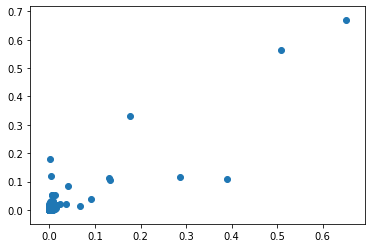

In [71]:
plt.scatter(wt_conn_old.loc['FRP5'], connectivity_matrices_wt_sumall.loc['FRP5'])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


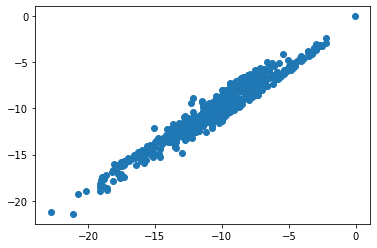

In [73]:
plt.scatter(np.log(wt_conn_old.loc['VISp4']), np.log(connectivity_matrices_wt_sumall.loc['VISp4']))

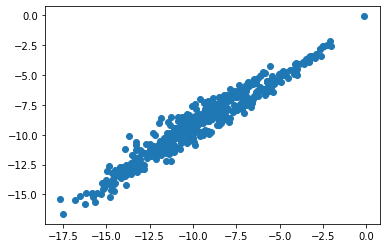

In [77]:
plt.scatter(np.log(wt_conn_old.loc['VISp5']), np.log(connectivity_matrices_wt_sumall.loc['VISp5']))

In [78]:
wt_conn_old.loc['VISp6a']

ipsi    FRP       NaN
        MOp       NaN
        MOs       NaN
        SSp-n     NaN
        SSp-bfd   NaN
                   ..
contra  PFL       NaN
        FL        NaN
        FN        NaN
        IP        NaN
        DN        NaN
Name: VISp6a, Length: 577, dtype: float64

In [79]:
connectivity_matrices_wt_sumall.loc['VISp6a']

first   second 
ipsi    FRP        7.770434e-05
        MOp        2.184474e-03
        MOs        8.380203e-03
        SSp-n      6.918965e-04
        SSp-bfd    5.430885e-03
                       ...     
contra  PFL        1.130568e-03
        FL         3.951964e-04
        FN         1.366436e-06
        IP         8.271518e-07
        DN         1.849836e-07
Name: VISp6a, Length: 577, dtype: float64

In [47]:
np.where(connectivity_matrices_wt_sumall.sum(axis = 1) !=0.)[0].shape

(186,)

In [57]:
np.where(connectivity_matrices_wt_sumall_old.sum(axis = 1) !=0.)[0].shape

(121,)

In [59]:
connectivity_matrices_wt_sumall

first           ipsi                                                  \
second           FRP           MOp           MOs     SSp-n   SSp-bfd   
FRP1             NaN           NaN           NaN       NaN       NaN   
FRP2/3  3.383236e-01  6.234344e-02  8.207796e-01  0.001093  0.000168   
FRP5    3.296336e-01  1.118266e-01  5.627480e-01  0.002927  0.000353   
FRP6a   4.342746e-01  5.693409e-03  3.965367e-01  0.000097  0.000032   
FRP6b            NaN           NaN           NaN       NaN       NaN   
...              ...           ...           ...       ...       ...   
PFL     1.439438e-05  7.948757e-03  3.006184e-03  0.008349  0.011361   
FL               NaN           NaN           NaN       NaN       NaN   
FN      0.000000e+00  5.117939e-04  2.613541e-04  0.000095  0.000166   
IP      5.706606e-19  8.766322e-18  9.152959e-08  0.000365  0.000087   
DN               NaN           NaN           NaN       NaN       NaN   

first                                                                     ...  \
second        SSp-ll     SSp-m        SSp-ul        SSp-tr        SSp-un  ...   
FRP1             NaN       NaN           NaN           NaN           NaN  ...   
FRP2/3  2.598411e-05  0.003196  3.725514e-04  9.797102e-06  1.883110e-05  ...   
FRP5    1.210437e-04  0.018610  5.827464e-03  2.795066e-05  7.172653e-04  ...   
FRP6a   0.000000e+00  0.004673  1.745053e-04  0.000000e+00  2.689954e-05  ...   
FRP6b            NaN       NaN           NaN           NaN           NaN  ...   
...              ...       ...           ...           ...           ...  ...   
PFL     3.687958e-03  0.008480  2.935677e-03  1.668404e-04  2.474538e-04  ...   
FL               NaN       NaN           NaN           NaN           NaN  ...   
FN      4.726471e-09  0.000337  2.743849e-05  3.489020e-08  2.008037e-08  ...   
IP      6.866135e-19  0.000561  6.127053e-07  4.967319e-19  4.729797e-19  ...   
DN               NaN       NaN           NaN           NaN           NaN  ...   

first     contra                                                        \
second       NOD       SIM            AN       PRM      COPY       PFL   
FRP1         NaN       NaN           NaN       NaN       NaN       NaN   
FRP2/3  0.000000  0.000000  0.000000e+00  0.000002  0.000000  0.000000   
FRP5    0.000133  0.000116  2.601491e-04  0.000282  0.000511  0.001011   
FRP6a   0.000000  0.000002  8.326684e-07  0.000002  0.000000  0.000227   
FRP6b        NaN       NaN           NaN       NaN       NaN       NaN   
...          ...       ...           ...       ...       ...       ...   
PFL     0.021769  0.094570  1.162284e-01  0.051984  0.036561  0.033771   
FL           NaN       NaN           NaN       NaN       NaN       NaN   
FN      0.000381  0.011068  4.310618e-02  0.030363  0.018532  0.000540   
IP      0.000092  0.000183  5.943723e-04  0.000234  0.000095  0.000110   
DN           NaN       NaN           NaN       NaN       NaN       NaN   

first                                                   
second        FL        FN            IP            DN  
FRP1         NaN       NaN           NaN           NaN  
FRP2/3  0.000000  0.000000  0.000000e+00  0.000000e+00  
FRP5    0.000190  0.000024  4.428778e-07  7.487731e-08  
FRP6a   0.000000  0.000000  0.000000e+00  0.000000e+00  
FRP6b        NaN       NaN           NaN           NaN  
...          ...       ...           ...           ...  
PFL     0.003145  0.000351  1.494835e-03  1.578074e-04  
FL           NaN       NaN           NaN           NaN  
FN      0.000070  0.052541  3.777179e-02  1.690367e-03  
IP      0.000042  0.000089  2.982120e-05  1.406795e-18  
DN           NaN       NaN           NaN           NaN  

[541 rows x 577 columns]

In [58]:
connectivity_matrices_wt_sumall_old

first       ipsi                                                        \
second       FRP       MOp       MOs     SSp-n   SSp-bfd        SSp-ll   
FRP1                                                                     
FRP2/3       NaN       NaN       NaN       NaN       NaN           NaN   
FRP5    0.175879  0.129804  0.508782  0.002452  0.000694  1.262551e-04   
FRP6a        NaN       NaN       NaN       NaN       NaN           NaN   
FRP6b        NaN       NaN       NaN       NaN       NaN           NaN   
MOp1         NaN       NaN       NaN       NaN       NaN           NaN   
...          ...       ...       ...       ...       ...           ...   
PFL     0.000016  0.008962  0.003389  0.009412  0.012808  4.157839e-03   
FL           NaN       NaN       NaN       NaN       NaN           NaN   
FN      0.000000  0.000512  0.000261  0.000095  0.000166  4.726471e-09   
IP      0.000041  0.000677  0.000224  0.000806  0.000757  4.778025e-05   
DN           NaN       NaN       NaN       NaN       NaN           NaN   

first                                                   ...    contra  \
second     SSp-m    SSp-ul        SSp-tr        SSp-un  ...       NOD   
FRP1                                                    ...             
FRP2/3       NaN       NaN           NaN           NaN  ...       NaN   
FRP5    0.015829  0.005540  7.043700e-05  6.353662e-04  ...  0.000010   
FRP6a        NaN       NaN           NaN           NaN  ...       NaN   
FRP6b        NaN       NaN           NaN           NaN  ...       NaN   
MOp1         NaN       NaN           NaN           NaN  ...       NaN   
...          ...       ...           ...           ...  ...       ...   
PFL     0.009561  0.003310  1.880975e-04  2.789818e-04  ...  0.024528   
FL           NaN       NaN           NaN           NaN  ...       NaN   
FN      0.000337  0.000027  3.489020e-08  2.008037e-08  ...  0.000381   
IP      0.001414  0.000149  2.980216e-05  2.768753e-05  ...  0.000103   
DN           NaN       NaN           NaN           NaN  ...       NaN   

first                                                               \
second       SIM        AN       PRM      COPY       PFL        FL   
FRP1                                                                 
FRP2/3       NaN       NaN       NaN       NaN       NaN       NaN   
FRP5    0.000279  0.000894  0.000211  0.000123  0.000728  0.000097   
FRP6a        NaN       NaN       NaN       NaN       NaN       NaN   
FRP6b        NaN       NaN       NaN       NaN       NaN       NaN   
MOp1         NaN       NaN       NaN       NaN       NaN       NaN   
...          ...       ...       ...       ...       ...       ...   
PFL     0.106602  0.130967  0.058597  0.041204  0.038068  0.003543   
FL           NaN       NaN       NaN       NaN       NaN       NaN   
FN      0.011068  0.043106  0.030363  0.018532  0.000540  0.000070   
IP      0.000161  0.000538  0.000659  0.001680  0.005055  0.000050   
DN           NaN       NaN       NaN       NaN       NaN       NaN   

first                                         
second            FN        IP            DN  
FRP1                                          
FRP2/3           NaN       NaN           NaN  
FRP5    2.060882e-07  0.000002  3.226770e-08  
FRP6a            NaN       NaN           NaN  
FRP6b            NaN       NaN           NaN  
MOp1             NaN       NaN           NaN  
...              ...       ...           ...  
PFL     3.959431e-04  0.001685  1.779135e-04  
FL               NaN       NaN           NaN  
FN      5.254120e-02  0.037772  1.690367e-03  
IP      1.630989e-04  0.000085  8.030446e-05  
DN               NaN       NaN           NaN  

[540 rows x 577 columns]

In [ ]:
conn2 = get_connectivity_matrices3(connectivity_data, surfaces, experiment_sids_surfaces,experiment_sids_nws, model_ordering, source_ordering_surface, source_ordering_nw, source_ordering, target_ordering, eval_cres)

In [69]:
#connectivity_data
surfaces = surfaces#_str
cres = crelist
structures_smooth = summary_structures#leafs
structures_surface = summary_structures#leafs
model_ordering = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
#model_ordering_surfaces = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
#model_ordering_leafs = model_ordering_leafs#[117:123]
#model_ordering_surfaces = model_ordering_summaries#[117:123]
ontological_order_leaves 
ontological_order_leaves_summary

eval_cres = eval_cres
source_ordering = ontological_order_leaves#[117:123]
target_ordering= ontological_order
#connectivity_matrices = get_connectivity_matrices3(connectivity_data, surfaces, cres, structures_smooth,structures_surface, model_ordering_leafs,  source_ordering, target_ordering, eval_cres)
#connectivity_matrices = get_connectivity_matrices3(connectivity_data, surfaces, cres, structures_smooth,structures_surface, model_ordering, source_ordering, target_ordering, eval_cres)
    

0 68.0


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


TypeError: unhashable type: 'numpy.ndarray'

In [70]:
    nsource = len(source_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan


In [84]:
c = 0 
i = 0
print(i,source_ordering[i])
sid = int(model_ordering[i,0])#structure_major_dictionary[source_ordering[i]]

sid = 315
structure_data = connectivity_data.structure_datas[sid]
structures_surface_sid = structures_surface[sid]
structures_smooth_sid = structures_smooth[sid]
prediction_region = source_ordering[i]
cre = eval_cres[c]
gamma = surfaces[sid].gamma
surface = surfaces[sid]


0 68.0


In [86]:
structures_surface_sid.shape

(1128,)

In [73]:
    nw_exp_ind = np.where(structures_smooth_sid == structures_smooth_sid)[0]
    te_exp_ind = np.where(structures_surface_sid == structures_surface_sid)[0]

    nexp_surface = len(te_exp_ind)
    cres_surface = structure_data.crelines[te_exp_ind]
    
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

    projections = structure_data.reg_proj_norm[nw_exp_ind]
    centroids = structure_data.centroids[nw_exp_ind]

    projections_surface = structure_data.reg_proj_norm[te_exp_ind]
    means = get_means(projections_surface, cres_surface, np.repeat(structures_surface_sid,nexp_surface))

    if centroids.shape[0]>0:
        #print(means)
        if np.isin(cre, np.asarray(list(means[structures_surface_sid].keys()))):
            losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres_surface, cre, means[model_region_surface])
            predictions = get_nw_predictions(projections, losses, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan
    else:
        output = np.zeros(projections.shape[1])
        output[:] = np.nan


TypeError: unhashable type: 'numpy.ndarray'

In [82]:
means.keys()

dict_keys([39, 44, 48, 104, 111, 119, 184, 329, 337, 345, 353, 361, 369, 378, 385, 394, 402, 409, 417, 425, 533, 541, 677, 723, 731, 746, 879, 886, 894, 895, 972, 985, 993, 1002, 1011, 1018, 1027, 1057, 182305689, 312782546, 312782574, 312782628])

In [77]:
means.keys()

dict_keys([39, 44, 48, 104, 111, 119, 184, 329, 337, 345, 353, 361, 369, 378, 385, 394, 402, 409, 417, 425, 533, 541, 677, 723, 731, 746, 879, 886, 894, 895, 972, 985, 993, 1002, 1011, 1018, 1027, 1057, 182305689, 312782546, 312782574, 312782628])

In [78]:
structures_surface_sid

array([886, 385, 993, ..., 385, 329, 993], dtype=object)

In [79]:
structures_surface_sid

array([886, 385, 993, ..., 385, 329, 993], dtype=object)